In [1]:
# 1. Load required libraries
suppressPackageStartupMessages({
  library(limma)
  library(edgeR)
  library(stringr) # For easy string manipulation
})

In [2]:
raw_df <- read.csv("/home/nilabjab/cancer_dependency_project_nilabja/cancer_dependency_project/Approach3_Latent_factor/Tahoe_analysis/Tahoe_erlotinib_dmso_pseudobulk_gene_level.csv", row.names = 1)


In [3]:
# ==============================================================================
# 2. Data Preparation
# ==============================================================================
# Assuming your data is loaded in a dataframe called 'raw_df'
# based on your description: Rows = Samples, Cols = Genes.
# We need to TRANSPOSE this because limma/edgeR expect Rows = Genes, Cols = Samples.

# Transpose the data
counts <- t(raw_df)

# Check dimensions (Should be ~62k rows, 300 columns)
print(dim(counts))

[1] 62189   300


In [4]:
# ==============================================================================
# 3. Metadata Extraction (The Design Logic)
# ==============================================================================
# We need to extract metadata from the column names (which were the sample rows)
sample_names <- colnames(counts)

# Helper function to extract Plate and Treatment info
# Logic: We split the string. 
# DMSO samples look like: "DMSO_Plate_7_..."
# Erlotinib samples look like: "Erlotinib_0.05_..." (or Plate info might be later)
# However, you stated the samples are annotated as DMSO/Erlotinib_Plate_x_...

# Let's extract metadata using regex for robustness
meta <- data.frame(Sample = sample_names, stringsAsFactors = FALSE)

# Extract Plate Number (looking for pattern "Plate_7", "Plate_8", etc.)
meta$Plate <- str_extract(sample_names, "Plate_\\d")

# Note: Your Erlotinib samples don't explicitly say "Plate" in the snippet 
# (e.g., "Erlotinib_0.05_CVCL_0023"), but you mapped them:
# 0.05 -> Plate 7, 0.5 -> Plate 8, 5 -> Plate 9.
# Let's handle this mapping logic:

# Extract Treatment type
meta$Treatment <- ifelse(grepl("DMSO", sample_names), "DMSO", "Erlotinib")

# Extract Concentration/Plate logic if explicit "Plate" text is missing in Erlotinib names
# We map known concentrations to plates as per your description
meta$Plate_Mapped <- NA
meta$Plate_Mapped[grepl("Plate_7", sample_names) | grepl("0\\.05", sample_names)] <- "Plate7"
meta$Plate_Mapped[grepl("Plate_8", sample_names) | grepl("0\\.5", sample_names)] <- "Plate8"
meta$Plate_Mapped[grepl("Plate_9", sample_names) | grepl("_5_", sample_names)] <- "Plate9"

# Create the specific "Group" for the design matrix
# This combines Treatment and Plate to separate dosages
meta$Group <- paste(meta$Treatment, meta$Plate_Mapped, sep="_")

# Convert to factor
meta$Group <- factor(meta$Group)

# (Optional) If you want to correct for Cell Line, extract it here
# The cell line appears to be the last part of the string after "CVCL_"
#meta$CellLine <- str_extract(sample_names, "CVCL_.*")

# View metadata to ensure logic is correct
head(meta)

,Sample,Plate,Treatment,Plate_Mapped,Group
,<chr>,<chr>,<chr>,<chr>,<fct>
1,DMSO_Plate_7_CVCL_0023,Plate_7,DMSO,Plate7,DMSO_Plate7
2,Erlotinib_0.05_CVCL_0023,NA,Erlotinib,Plate7,Erlotinib_Plate7
3,DMSO_Plate_7_CVCL_0028,Plate_7,DMSO,Plate7,DMSO_Plate7
4,Erlotinib_0.05_CVCL_0028,NA,Erlotinib,Plate7,Erlotinib_Plate7
5,DMSO_Plate_7_CVCL_0069,Plate_7,DMSO,Plate7,DMSO_Plate7
6,Erlotinib_0.05_CVCL_0069,NA,Erlotinib,Plate7,Erlotinib_Plate7


In [5]:
# Create DGEList
d0 <- DGEList(counts = counts, group = meta$Group)

#keep <- filterByExpr(d0, group = meta$Group)  # <--- Commented out
#d <- d0[keep, , keep.lib.sizes=FALSE]         # <--- Commented out

d <- d0  # <--- ADD THIS LINE (Pass the full dataset to the variable 'd')

In [6]:
# ==============================================================================
# 5. Normalization Factors (TMM)
# ==============================================================================
# Calculate normalization factors (TMM is the standard method used before voom)
d <- calcNormFactors(d, method = "TMM")

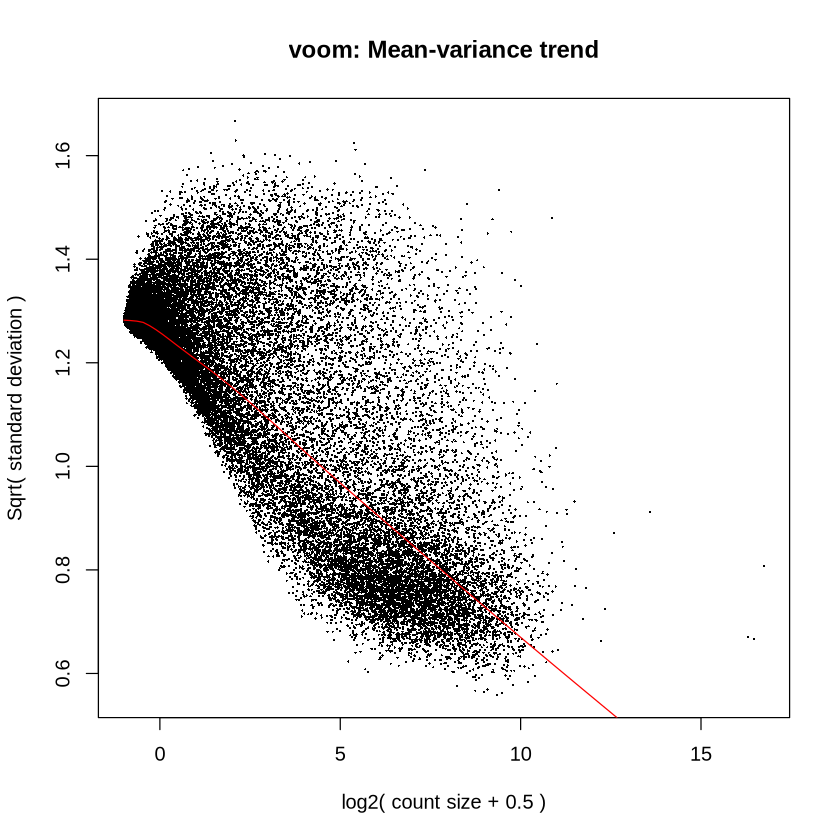

In [7]:
# ==============================================================================
# 6. Design Matrix and Voom
# ==============================================================================
# We use a cell-means model (~0 + Group)
# This allows us to estimate the variability for every specific condition separately.
design <- model.matrix(~0 + Group, data = meta)

# Fix column names of design matrix to be clean (removes "Group" prefix)
colnames(design) <- gsub("Group", "", colnames(design))

# Run Voom
# What this does:
# 1. Converts counts to log2-CPM (Normalized Data).
# 2. Estimates the mean-variance trend (Precision Weights).
v <- voom(d, design, plot = TRUE)

In [8]:
# ==============================================================================
# 7. Extract the Normalized Matrix
# ==============================================================================
# v$E contains the normalized log2-CPM values
normalized_matrix <- v$E

# Transpose back if you want Samples as Rows (matching your input format)
final_output <- t(normalized_matrix)

# Check output
dim(final_output)
head(final_output[,1:5]) 

[1]   300 62189

,X5S_rRNA,X5S_rRNA.1,X5S_rRNA.2,X5S_rRNA.3,X5S_rRNA.4
DMSO_Plate_7_CVCL_0023,-2.7441718,-2.7441718,-2.7441718,-2.7441718,-2.7441718
Erlotinib_0.05_CVCL_0023,-2.6302553,-2.6302553,-2.6302553,-2.6302553,-2.6302553
DMSO_Plate_7_CVCL_0028,-0.8239674,-0.8239674,-0.8239674,-0.8239674,-0.8239674
Erlotinib_0.05_CVCL_0028,-0.3067319,-0.3067319,-0.3067319,-0.3067319,-0.3067319
DMSO_Plate_7_CVCL_0069,-2.7728886,-2.7728886,-2.7728886,-2.7728886,-2.7728886
Erlotinib_0.05_CVCL_0069,-2.9091066,-2.9091066,-2.9091066,-2.9091066,-2.9091066


In [ ]:
write.csv(final_output,
          file = "Tahoe_voom_exp_final.csv",
          quote = FALSE,
          row.names = TRUE)
